# Quantum Stock Picking and Quantum Portfolio Optimization


## Introduction

This assignment will shows how we can use mean-variance optimization to pick stocks for a problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Variational Quantum Eigensolver (VQE) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
<br>
[Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.](https://arxiv.org/abs/1907.04769)

Note: We are not using CVaR as a portfolio statistic here, rather as a heuristic in our VQE procedure, curious students are encouraged to read the paper above.

#### To Students: Complete the following sections labeled todo

In [14]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.utils import algorithm_globals

import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas
import pandas as pd

def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [15]:
from qiskit import IBMQ
IBMQ.save_account('da32a753e4b64c6642853df5bf6ef39ac6ddc3a6759ff9ed6db13d0efc643cf558952b57653c76d90827999be221538703bcc08228a1d627f39755ec8cf6d18a', overwrite=True)

In [16]:
#global random seed used throuhgout
seed = 123

In [17]:
# Generate expected return and covariance matrix from (random) time-series

#Todo pick candidate stocks, 3-8 are recommended, stick to 4 if you're going to submit a real quantum experiment to IBM's cloud:

stocks = ['BABA', 'GOOGL', 'IBM', 'NVDA', 'AMD']

# Here are some quantum themed stocks :) 
# ['IBM','AMD','ACN','NVDA','GOOGL','MSFT','AMZN','MU','BABA']
# Feel free to pick any in this list or beyond
    
num_assets = len(stocks)

#IBM has done us a favour and provided a cute data provider they designed.
data = YahooDataProvider(tickers=stocks,
                 start=pandas.Timestamp('2019'),
                 end=pandas.Timestamp.now())
data.run()

# Here we pull apart the IBM qiskit_finance.data_provider internals to retreive our data and format as a pandas DataFrame
df = pandas.DataFrame({data._tickers[tidx]:data._data[tidx] for tidx in range(len(data._tickers))})

# Provided by IBM
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [18]:
q = 0.50                   #  risk appetite 
budget = num_assets  //2   #  stocks to allocate
penalty = num_assets       #  set parameter to scale the budget penalty term
bounds = None              #  Allocation percent: None: 100%

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,bounds=bounds)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000249582928 x_0 - 0.001532605688 x_1 - 0.000447521568 x_2
      - 0.003505910044 x_3 - 0.003426598083 x_4 + [ 0.000564413710 x_0^2
      + 0.000366899575 x_0*x_1 + 0.000237891990 x_0*x_2 + 0.000611304592 x_0*x_3
      + 0.000566016740 x_0*x_4 + 0.000353528152 x_1^2 + 0.000344666305 x_1*x_2
      + 0.000700914079 x_1*x_3 + 0.000631007721 x_1*x_4 + 0.000353561549 x_2^2
      + 0.000453239216 x_2*x_3 + 0.000421738393 x_2*x_4 + 0.000905628041 x_3^2
      + 0.001415578719 x_3*x_4 + 0.001106275673 x_4^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 + x_4 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End

## Solution using VQE
We can now use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used.

Note: You can switch to different backends by providing the name of backend.

In [19]:
algorithm_globals.random_seed = seed+1
backend = Aer.get_backend('statevector_simulator')


cobyla = COBYLA()
cobyla.set_options(maxiter=500)

ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)

result = vqe.solve(qp)


# print(result.fval)
print_result(result)

Optimal: selection [0. 0. 0. 1. 1.], value -0.0052

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1]	-0.0029		0.6185
[0 1 1 0 0]	-0.0015		0.3764
[1 1 0 0 0]	-0.0011		0.0019
[0 1 0 0 1]	-0.0039		0.0010
[0 1 0 1 0]	-0.0041		0.0007
[0 0 0 1 1]	-0.0052		0.0006
[1 0 0 0 1]	-0.0026		0.0004
[1 0 1 0 0]	-0.0001		0.0001
[1 1 1 0 0]	1.0126		0.0001
[1 1 0 0 1]	1.0103		0.0001
[1 0 1 0 1]	1.0112		0.0000
[1 0 0 0 0]	1.0137		0.0000
[1 0 0 1 1]	1.0091		0.0000
[1 1 0 1 0]	1.0101		0.0000
[0 0 0 1 0]	1.0106		0.0000
[0 0 0 0 0]	4.0547		0.0000
[1 0 0 1 0]	-0.0027		0.0000
[0 0 1 0 0]	1.0134		0.0000
[1 1 1 1 0]	4.0514		0.0000
[1 1 1 0 1]	4.0515		0.0000
[0 0 1 1 1]	1.0086		0.0000
[1 0 1 1 1]	4.0504		0.0000
[0 1 1 0 1]	1.0099		0.0000
[1 0 1 1 0]	1.0110		0.0000
[0 1 0 0 0]	1.0123		0.0000
[0 1 0 1 1]	1.0078		0.0000
[0 0 0 0 1]	1.0108		0.0000
[0 1 1 1 0]	1.0097		0.0000
[0 1 1 1 1]	4.0491		0.0000
[0 0 1 1 0]	-0.0031		0.

In [20]:
selected_stocks = list(np.array(stocks)[result.x.astype('bool')])
print(f"Stocks from our Qunatum Stock Picking algorthm selected: {selected_stocks}")

Stocks from our Qunatum Stock Picking algorthm selected: ['NVDA', 'AMD']


### Student todo, complete an equity curve, CAGR and IR comparison for the portfolio of all the stocks you selected for optimization compared to one which your Quantum Stock picker put together

hints:


df[selected_stocks] contains a data frame with your stock pick prices.   
df is the full list of stocks you started with.

IR selection: 1.88
IR all: 1.53 

CAGR selection: 206.66%
CAGR all: 134.12%


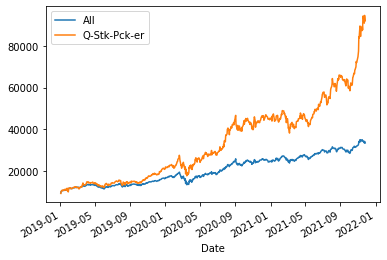

In [21]:
all_df = df
sel_df = df[selected_stocks]

all_df_dr = all_df.pct_change().dropna().mean(axis=1)
sel_df_dr = sel_df.pct_change().dropna().mean(axis=1)

eq_all = 10000*all_df_dr.add(1).cumprod()
eq_sel = 10000*sel_df_dr.add(1).cumprod()

eq_all.plot()
eq_sel.plot()
plt.legend(['All', 'Q-Stk-Pck-er'])

IR_sel = (sel_df_dr.mean() / sel_df_dr.std()) * (252) ** 0.5
IR_all = (all_df_dr.mean() / all_df_dr.std()) * (252) ** 0.5


print(f"IR selection: {round(IR_sel,2)}")
print(f"IR all: {round(IR_all,2)} \n")

CAGR_all = 100*((eq_all.iloc[-1]/10000)-1) ** (252/len(eq_all))
CAGR_sel = 100*((eq_sel.iloc[-1]/10000)-1) ** (365/(df.index[-1] - df.index[0]).days)

print(f"CAGR selection: {round(CAGR_sel,2)}%")
print(f"CAGR all: {round(CAGR_all,2)}%")


# (Optional) For Advanced Students:

## Here we will make some modifications to do portfolio optimization


This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{j ... k\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{-j, +k\}^n$ denotes the vector of weight allocation variables, which indicate the relative allocation to assign. 
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to allocate exactly $B$ relative amounts of asset.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This rest of this notebook shows how to use the Variational Quantum Eigensolver (VQE) an optimal solution for a given set of parameters.

In [ ]:

q = 0.50                   #  risk appetite 
budget = num_assets        #  Units to allocate
penalty = num_assets //2   #  set parameter to scale the budget penalty term
bounds = [(#todo,#todo)]*num_assets  #  Allocation units, can be negative or positive


portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,bounds=bounds)
qp = portfolio.to_quadratic_program()
qp

In [ ]:
algorithm_globals.random_seed = seed+1
backend = Aer.get_backend('statevector_simulator')


cobyla = COBYLA()
cobyla.set_options(maxiter=500)

ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)

result = vqe.solve(qp)

In [ ]:
allocations = pandas.DataFrame({f"{stocks[tidx]}":result.x[tidx] for tidx in range(len(stocks))},index=['Allocation'])

### Student todo, complete an equity curve, CAGR and IR comparison for the a portfolio of all the stocks you selected for optimization compared to one which your Quantum Portfolio Optimzer put together.

hints:


The variable allocations contains a DataFrame with your relative stock allocations.   
df is the full list of stocks you started with.